# 1. PBMC data with covariates

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Scanpro functions
from scanpro import scanpro
from scanpro.utils import convert_counts_to_df

In [2]:
# path where figures are going to be saved
FIG_PATH = 'plots'

## Read data

In [3]:
pbmc_counts = pd.read_csv("data/pbmc_counts.tsv", sep="\t")

In [4]:
# Convert count matrix to long format
pbmc = convert_counts_to_df(pbmc_counts, column_name="Celltype")
pbmc.head()

,Sample,Condition,Sex,Age,Celltype
cell_1,OF1,OF,Female,Old,B cells
cell_2,OF1,OF,Female,Old,B cells
cell_3,OF1,OF,Female,Old,B cells
cell_4,OF1,OF,Female,Old,B cells
cell_5,OF1,OF,Female,Old,B cells


## Run Scanpro

In [5]:
columns = ["Age", "Sex"]
transformations = ["logit", "arcsin"]

result_tables = []
for conds_col in columns:
    covariate_col = [col for col in columns if col != conds_col][0]
    for covariate in [[covariate_col], None]:
        for transform in transformations:
            scanpro_out = scanpro(pbmc, samples_col="Sample", clusters_col='Celltype', 
                                  conds_col=conds_col, 
                                  transform=transform,
                                  covariates=covariate,
                                  verbosity=0)

            table = scanpro_out.results
            table["conds_col"] = conds_col
            table["covariate"] = covariate[0] if covariate is not None else None
            table["transform"] = transform

            result_tables.append(table)

## Compare p-values

In [6]:
combined_results = pd.concat(result_tables).reset_index()
combined_results.sort_values(["transform", "covariate"], inplace=True)

In [7]:
combined_results["combination"] = "covariate=" + combined_results["covariate"].astype(str) + " | transform=" + combined_results["transform"]

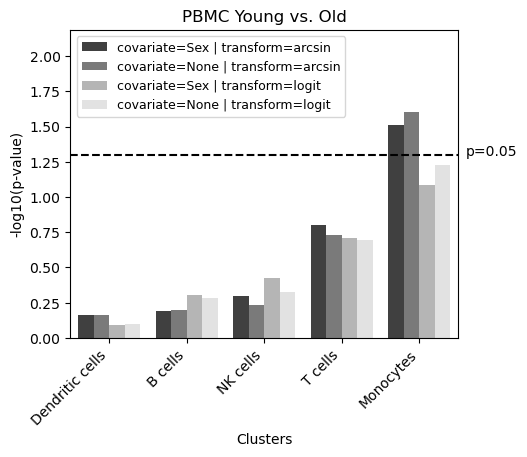

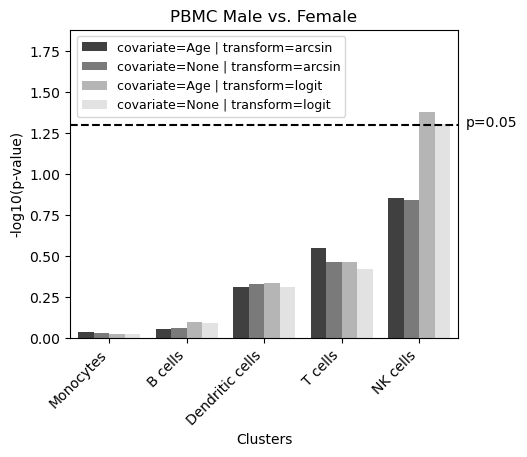

In [8]:
for conds_col, table in combined_results.groupby("conds_col"):
    
    table["-log10(p-value)"] = -np.log10(table["adjusted_p_values"])
    
    x_order = table.groupby("clusters")["adjusted_p_values"].mean().sort_values(ascending=False).index
    
    fig, ax = plt.subplots(figsize=(5,4))
    
    ax = sns.barplot(data=table, x="clusters", y="-log10(p-value)", hue="combination", 
                     palette="Greys_r", ax=ax, order=x_order)
    ax.axhline(-np.log10(0.05), color="black", ls="--")
    ax.text(4.6, -np.log10(0.051), "p=0.05")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_xlabel("Clusters")
    
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], ylim[1]*1.3)
    
    sns.move_legend(ax, "upper left", bbox_to_anchor=(0,1), title="", fontsize=9)
    
    if conds_col == "Sex":
        ax.set_title("PBMC Male vs. Female")
    else:
        ax.set_title("PBMC Young vs. Old")
        
    plt.savefig(f"{FIG_PATH}/pbmc_{conds_col}_covariate.pdf")
    plt.show()